# Pilot Study v2

Two experiments: **GPT-4.1** and **Gemini 3.0 Flash** scoring news articles on a 4-point fascism rubric.

Data is pulled via `judge_gym.collect.pull_experiments` (single bulk Convex query per experiment).

In [10]:
import ast
import json

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize as mplNormalize
import pandas as pd
import seaborn as sns

import re
import numpy as np
import statsmodels.formula.api as smf


from judge_gym.collect import pull_experiments

In [ ]:
TAGS = [
    "ecc-fascism-usa-trial-gpt-4.1",
    "ecc-fascism-usa-trial-gemini-3.0-flash",
]

data = pull_experiments(TAGS)
print(f"Tags pulled: {data.tags}")
print(f"Scale size:  {data.scale_size}")
print(f"Scores:      {len(data.scores)} rows")
print(f"Evidence:    {len(data.evidence)} articles")

Tags pulled: ['ecc-fascism-usa-trial-gpt-4.1', 'ecc-fascism-usa-trial-gemini-3.0-flash']
Scale size:  4
Scores:      540 rows
Evidence:    9 articles


## Evidence

In [68]:
scores = data.scores.copy()
eid_to_label = dict(zip(data.evidence["evidenceId"], data.evidence["label"]))
scores["evidence"] = scores["evidenceId"].map(eid_to_label)

data.evidence[["label", "title"]]

,label,title
0,E1,Why Fascists Always Come for the Socialists First
1,E2,Being ‘American’
2,E3,The most significant question for Trump’s Amer...
3,E4,Surgical coup in the fascist backyard
4,E5,Where’s the outrage?
5,E6,"Colombia, Cuba and Mexico: Are these Trump's n..."
6,E7,Free the Maduros! Jail Trump!
7,E8,As Trump Expands Imperial Aggression in Venezu...
8,E9,Critical Education in the Age of Trump’s Fasci...


## Subset-exploded stage counts per evidence

Stacked bar charts showing the distribution of individual stages chosen across all verdicts,
plus abstain rates. Each verdict is exploded into its component stages (e.g., `[2,3]` → stage 2 + stage 3).

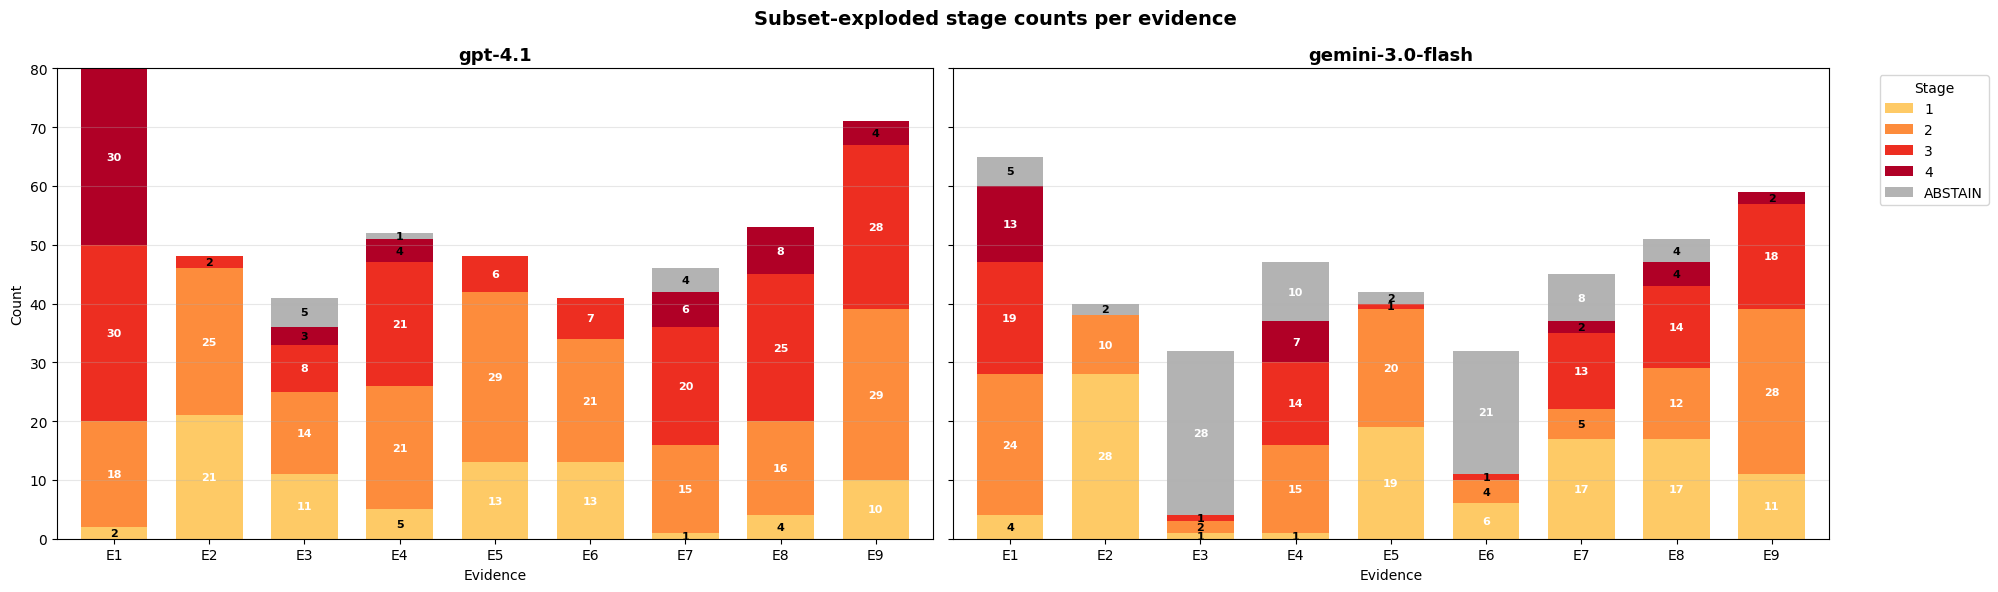

In [69]:
# --- Subset-exploded stage counts per evidence ---
# Vertical stacked bar charts, one panel per model (side by side).
# Each verdict is exploded into component stages, plus abstain counts.

def _explode_stages(row):
    """Explode a verdict into individual stage selections."""
    if row["abstained"]:
        return ["ABSTAIN"]
    else:
        return row["decodedScores"]

# Build exploded stage counts per evidence per model
n_models = len(data.tags)
fig, axes = plt.subplots(1, n_models, figsize=(10 * n_models, 6), sharey=True)
if n_models == 1:
    axes = [axes]

# Get all stages + ABSTAIN
all_stages = list(range(1, data.scale_size + 1)) + ["ABSTAIN"]

# Heat scale colors: stage 1 (coolest) to stage 4 (hottest), then grey for ABSTAIN
# Using YlOrRd colormap for heat scale
heat_colors = plt.cm.YlOrRd(np.linspace(0.3, 0.9, data.scale_size))
stage_colors = list(heat_colors) + [(0.7, 0.7, 0.7)]  # Add grey for ABSTAIN

for idx, (ax, tag) in enumerate(zip(axes, data.tags)):
    model = data.experiments[tag]["modelId"]
    sub = scores[scores["experimentTag"] == tag].copy()
    
    # Explode verdicts into individual stages
    sub["stages"] = sub.apply(_explode_stages, axis=1)
    exploded = sub.explode("stages")
    
    # Count stages per evidence
    ev_labels = sorted(eid_to_label.values(), key=lambda l: int(l[1:]))
    stage_counts = (
        exploded.groupby(["evidence", "stages"])
        .size()
        .unstack(fill_value=0)
    )
    
    # Reindex to ensure all stages and evidence are present
    stage_counts = stage_counts.reindex(index=ev_labels, columns=all_stages, fill_value=0)
    
    # Create vertical stacked bar chart
    stage_counts.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=stage_colors,
        width=0.7,
        legend=(idx == n_models - 1),  # Only show legend on rightmost panel
    )
    
    ax.set_title(f"{model}", fontsize=13, fontweight="bold")
    ax.set_ylabel("Count")
    ax.set_xlabel("Evidence")
    ax.grid(axis="y", alpha=0.3)
    ax.set_xticklabels(ev_labels, rotation=0)
    
    # Add count annotations on bars
    for i, evidence in enumerate(ev_labels):
        cumulative = 0
        for stage in all_stages:
            count = stage_counts.loc[evidence, stage]
            if count > 0:
                ax.text(
                    i,
                    cumulative + count / 2,
                    str(int(count)),
                    ha="center",
                    va="center",
                    fontsize=8,
                    fontweight="bold",
                    color="white" if count > 5 else "black",
                )
                cumulative += count

# Adjust legend
if n_models > 0:
    axes[-1].legend(
        title="Stage",
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        frameon=True,
    )

fig.suptitle(
    "Subset-exploded stage counts per evidence",
    fontsize=14,
    fontweight="bold",
    y=0.98,
)
plt.tight_layout()
plt.show()

## Rubric stage length bias analysis

Following Dubois et al. (2024), we test whether models exhibit systematic bias toward longer
or shorter rubric stage descriptions. We run both pooled (across all rubrics) and per-rubric
regressions to assess length effects.

**Key finding**: Length bias is **highly heterogeneous across rubrics** — some rubrics show
strong positive bias (prefer longer stages), others show strong negative bias (prefer shorter),
with effects ranging from -0.29 to +0.30. The pooled effect averages to near-zero, masking
this variation. Given this heterogeneity, we **do not apply a length discount** — any global
correction would be arbitrary and could amplify bias in rubrics where the effect runs opposite
to the average.

### Notes
- Given Multiple testing: With 30 rubrics × 2 models = 60 tests, ~3 will be "significant" by chance at p < 0.05. Could use Bonferroni correction (p < 0.05/60 = 0.0008) Or FDR correction (less conservative).
- Could use a signficance based adjustment when there's statistical evidence of length bias with per rubric, adjusted by direction. 

In [70]:
# --- Rubric stage length bias regression ---

# Flatten rubric quality stats if present
rubrics = data.rubrics.copy()
if rubrics.empty:
    raise ValueError("No rubrics returned. Check Convex endpoint.")

if "qualityStats" in rubrics.columns:
    rubrics["observabilityScore"] = rubrics["qualityStats"].apply(
        lambda q: q.get("observabilityScore") if isinstance(q, dict) else np.nan
    )
    rubrics["discriminabilityScore"] = rubrics["qualityStats"].apply(
        lambda q: q.get("discriminabilityScore") if isinstance(q, dict) else np.nan
    )

def _word_count(text: str) -> int:
    """Count words in a text string."""
    tokens = re.split(r"\s+", (text or "").strip())
    return len([t for t in tokens if t])

def _stage_text(stage: dict) -> str:
    """Concatenate stage label + criteria into a single text string."""
    parts = [stage.get("label", "")]
    parts.extend(stage.get("criteria", []))
    return " ".join([p for p in parts if p])

# Build stage-level table: one row per rubric stage
stage_rows = []
for _, r in rubrics.iterrows():
    stages = r.get("stages") or []
    for idx, stage in enumerate(stages, start=1):
        stage_rows.append({
            "rubricId": r["rubricId"],
            "stage": idx,
            "stage_len": _word_count(_stage_text(stage)),
            "observabilityScore": r.get("observabilityScore"),
            "discriminabilityScore": r.get("discriminabilityScore"),
        })

stage_df = pd.DataFrame(stage_rows)

# Z-score stage length within each rubric
stage_df["stage_len_z"] = stage_df.groupby("rubricId")["stage_len"].transform(
    lambda s: (s - s.mean()) / s.std(ddof=0) if s.std(ddof=0) > 0 else 0.0
)

# Add score ID before expanding (so we can group back later)
scores["scoreId"] = scores.index

# Expand scores to score × stage rows for regression
score_stage = scores.merge(stage_df, on="rubricId", how="left")
score_stage["selected"] = score_stage.apply(
    lambda r: 0 if r["abstained"] or r["decodedScores"] is None
    else int(r["stage"] in r["decodedScores"]),
    axis=1,
)

# Fit stage-length bias per model (linear probability model)
# DV: selected (0/1), IV: stage_len_z + fixed effects for evidence + rubric quality
betas = {}
for tag in data.tags:
    model = data.experiments[tag]["modelId"]
    sub = score_stage[score_stage["experimentTag"] == tag].copy()
    sub = sub[~sub["abstained"]]  # exclude abstains from regression
    if sub.empty:
        betas[model] = 0.0
        continue
    formula = "selected ~ stage_len_z + C(evidence) + observabilityScore + discriminabilityScore"
    res = smf.ols(formula, data=sub).fit()
    betas[model] = float(res.params.get("stage_len_z", 0.0))
    print(f"{model}: stage_len_z beta = {betas[model]:.4f} (n={len(sub)}, p={res.pvalues.get('stage_len_z', np.nan):.4f})")

# Rubric quality proxy and final adjusted probe
rubric_quality = stage_df.groupby("rubricId")[["observabilityScore", "discriminabilityScore"]].first().reset_index()
scores = scores.merge(rubric_quality, on="rubricId", how="left")
scores["p_rubric"] = scores["observabilityScore"] * scores["discriminabilityScore"]
scores["p_score"] = scores["expertAgreementProb"]
scores["p_adjusted"] = scores["p_score"] * scores["p_rubric"]  # No length discount

# Per-rubric regressions to see heterogeneity in length bias
print("\n=== Per-rubric length bias regressions ===")

for tag in data.tags:
    model = data.experiments[tag]["modelId"]
    sub = score_stage[score_stage["experimentTag"] == tag].copy()
    sub = sub[~sub["abstained"]]
    
    rubric_results = []
    for rubric_id in sub["rubricId"].unique():
        rubric_sub = sub[sub["rubricId"] == rubric_id].copy()
        
        # Need at least some variation to fit
        if rubric_sub["selected"].nunique() < 2 or len(rubric_sub) < 10:
            continue
        
        # Simple regression: selected ~ stage_len_z (no other controls, just length effect)
        try:
            formula = "selected ~ stage_len_z"
            res_rubric = smf.ols(formula, data=rubric_sub).fit()
            
            rubric_results.append({
                "rubricId": rubric_id,
                "beta": res_rubric.params.get("stage_len_z", np.nan),
                "pvalue": res_rubric.pvalues.get("stage_len_z", np.nan),
                "n_obs": len(rubric_sub),
                "n_selected": rubric_sub["selected"].sum(),
            })
        except:
            continue
    
    rubric_df = pd.DataFrame(rubric_results)
    rubric_df["selection_rate"] = rubric_df["n_selected"] / rubric_df["n_obs"]
    
    
    print(f"\n--- {model} ---")
    print(f"Overall beta: {betas[model]:.4f}")
    print(f"Rubrics analyzed: {len(rubric_df)}")
    print(f"\nTop 10 rubrics by absolute beta (strongest length effects):")
    
    top_rubrics = rubric_df.sort_values("beta", key=abs, ascending=False).head(10)
    display(top_rubrics[["rubricId", "beta", "pvalue", "selection_rate", "n_obs"]].style.format({
        "beta": "{:.4f}",
        "pvalue": "{:.4f}",
        "selection_rate": "{:.3f}",
        "n_obs": "{:.0f}",
    }).hide(axis="index"))

gpt-4.1: stage_len_z beta = -0.0064 (n=1040, p=0.6753)
gemini-3.0-flash: stage_len_z beta = -0.0463 (n=760, p=0.0094)

=== Per-rubric length bias regressions ===

--- gpt-4.1 ---
Overall beta: -0.0064
Rubrics analyzed: 30

Top 10 rubrics by absolute beta (strongest length effects):


rubricId,beta,pvalue,selection_rate,n_obs
jh7aj7mjd7cv2ycj7v7jk2g95n80v33n,0.3034,0.0001,0.472,36
jh75e2zwbktkk4x3w05vbz00nn80v9nj,-0.2403,0.0026,0.583,36
jh721ykx77crjb2wzahvkxc8kn80tt82,0.2356,0.0064,0.469,32
jh7bvht9w6tmjzyesrf9zfyhgh80vnw1,-0.2318,0.0064,0.406,32
jh70jhm2ff0mk2ds12zwtr2hg980v7j3,0.2021,0.0138,0.444,36
jh77sbvnv4ymtgdpfb0ngs033s80tmab,-0.1863,0.0250,0.472,36
jh7aff6em29shrgcgd0t0bvd4980tjvb,-0.1832,0.0277,0.472,36
jh79wkn3x8b0z41ky3xy2h45e980v9zt,-0.1790,0.0403,0.406,32
jh7fmqpna235kw56wrc9q89med80t4hm,-0.1550,0.0619,0.583,36
jh76d0w8tfnm4xw3asvhykw0ss80tcsj,0.1485,0.1248,0.500,28



--- gemini-3.0-flash ---
Overall beta: -0.0463
Rubrics analyzed: 30

Top 10 rubrics by absolute beta (strongest length effects):


rubricId,beta,pvalue,selection_rate,n_obs
jh7drw2zzcryjmnf75pa7wpw4980te2c,-0.2928,0.0087,0.312,16
jh7f17v1k0ch1mmv3mq7nbb6hn80vgp3,-0.2643,0.0029,0.393,28
jh7cdp1pnwga79j34x7f3qjrb180trhr,0.2604,0.0051,0.333,24
jh708rrfcm23psx7dzmkvxyses80tgnz,0.2547,0.0036,0.357,28
jh777d4zmcwwd7rrp88zace9bx80tvsf,-0.2409,0.0305,0.450,20
jh76ge61sjewgja6yhhe1k7n9d80v8kr,-0.2360,0.0059,0.438,32
jh7arggdswca71tasjsm9ke3bd80tgrp,-0.2138,0.0307,0.375,24
jh7874gs765g9cc9vn5028m2kd80vnh6,0.2029,0.0088,0.333,36
jh77ty7kqhrmtta0txwxavctms80t736,0.1815,0.0550,0.429,28
jh795q9kmwcc0jxksn9jwja2t980t2f0,-0.1809,0.1091,0.400,20


## Abstain & specificity rates per evidence

In [71]:
# Abstain and singleton rates (uses scores + eid_to_label from regression cell above)

def rates_table(scores: pd.DataFrame) -> pd.DataFrame:
    """Per model: abstain % and singleton-commit % for each evidence.

    Columns use 'E1 (N=30)' notation so the sample size is in the header.
    Rows are multi-indexed: (model, metric).
    """
    labels = sorted(eid_to_label.values(), key=lambda l: int(l[1:]))

    records = []
    for tag in data.tags:
        sub = scores[scores["experimentTag"] == tag]
        model = data.experiments[tag]["modelId"]
        abstain_row = {}
        single_row = {}

        for label in labels:
            g = sub[sub["evidence"] == label]
            n = len(g)
            col = f"{label} (N={n})"
            # Abstain rate
            a = g["abstained"].sum()
            abstain_row[col] = f"{a / n * 100:.0f}%" if n else "—"
            # Singleton rate (of non-abstained)
            non_abs = g[~g["abstained"]]
            nn = len(non_abs)
            s = non_abs["decodedScores"].apply(len).eq(1).sum() if nn else 0
            single_row[col] = f"{s / nn * 100:.0f}%" if nn else "—"

        # Total column
        n_total = len(sub)
        a_total = sub["abstained"].sum()
        non_abs_total = sub[~sub["abstained"]]
        nn_total = len(non_abs_total)
        s_total = non_abs_total["decodedScores"].apply(len).eq(1).sum() if nn_total else 0

        abstain_row[f"Total (N={n_total})"] = f"{a_total / n_total * 100:.0f}%"
        single_row[f"Total (N={n_total})"] = f"{s_total / nn_total * 100:.0f}%" if nn_total else "—"

        records.append((model, "Abstain %", abstain_row))
        records.append((model, "Singleton %", single_row))

    idx = pd.MultiIndex.from_tuples([(r[0], r[1]) for r in records])
    return pd.DataFrame([r[2] for r in records], index=idx)

rates_table(scores)

E1 (N=30) E2 (N=30) E3 (N=30) E4 (N=30)  \
gpt-4.1          Abstain %          0%        0%       17%        3%   
                 Singleton %        0%       40%       64%       31%   
gemini-3.0-flash Abstain %         17%        7%       93%       33%   
                 Singleton %       16%       64%       50%       50%   

                             E5 (N=30) E6 (N=30) E7 (N=30) E8 (N=30)  \
gpt-4.1          Abstain %          0%        0%       13%        0%   
                 Singleton %       40%       63%       50%       30%   
gemini-3.0-flash Abstain %          7%       70%       27%       13%   
                 Singleton %       57%       78%       45%       42%   

                             E9 (N=30) Total (N=270)  
gpt-4.1          Abstain %          0%            4%  
                 Singleton %        3%           35%  
gemini-3.0-flash Abstain %          0%           30%  
                 Singleton %       20%           44%

### Verdict distribution heatmaps with proportions and average expert probe

Each cell displays **(proportion, avg expertAgreementProb)** for that evidence-verdict combination,
both formatted with 2 decimal places. All responses — **including abstains** — are included. 
Each row (evidence) is normalized to sum to 1.

One panel per model, stacked vertically. Columns are powerset verdicts sorted by
center-of-gravity, then cardinality. Empty cells (0.00) are left blank.

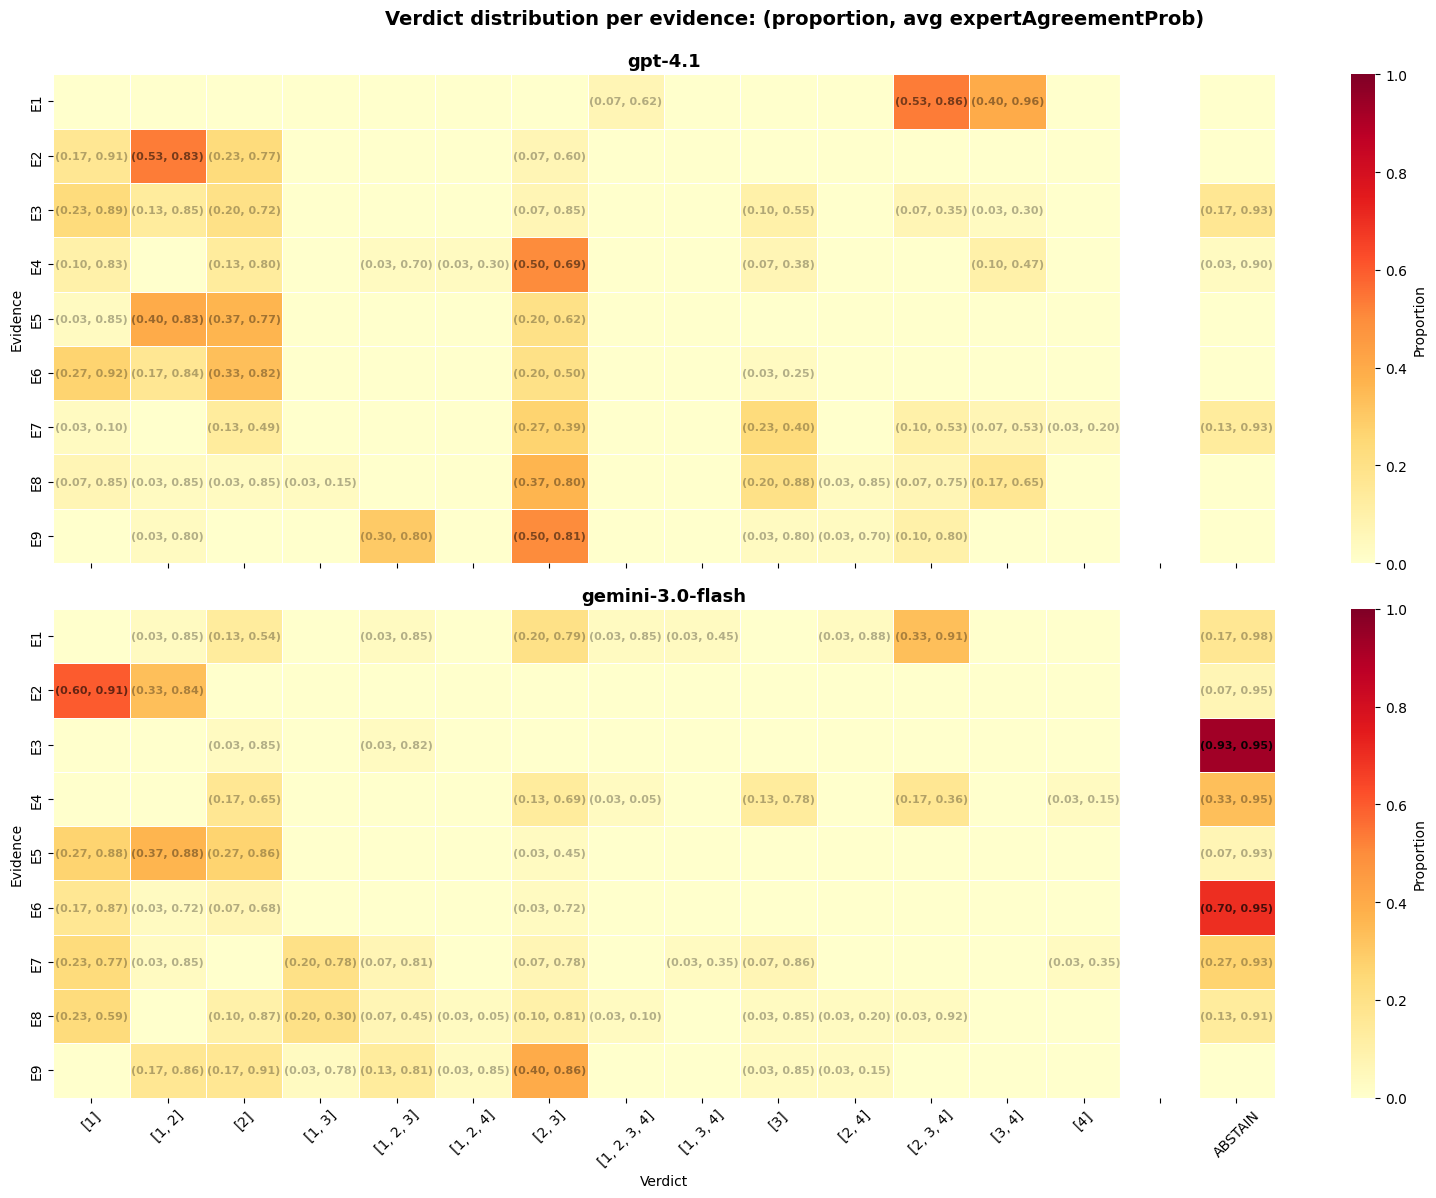

In [72]:
# --- Verdict distribution heatmaps with proportions and average expert probe ---
# One panel per model (stacked vertically). Evidence on y-axis, powerset verdicts on x-axis.
# Each cell shows (proportion [0,1], avg_expertAgreementProb) with 2 sig figs.
# Rows are normalized to sum to 1. A thin visual separator is drawn before ABSTAIN.

def _col_sort_key(col: str):
    """Sort verdict columns: by center-of-gravity, then cardinality, then elements.
    ABSTAIN always sorts last."""
    if col == "ABSTAIN":
        return (999, 0, [])
    stages = ast.literal_eval(col)  # e.g. "[2, 3]" -> [2, 3]
    cog = sum(stages) / len(stages)
    return (cog, len(stages), stages)

# Collect all verdicts across all models
tmp_all = scores.copy()
tmp_all["verdict"] = tmp_all.apply(
    lambda r: "ABSTAIN" if r["abstained"] else str(sorted(r["decodedScores"])),
    axis=1,
)
all_verdicts = sorted(tmp_all["verdict"].unique(), key=_col_sort_key)

def _build_count_and_avg_matrices(sub: pd.DataFrame, all_verdicts: list) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Build evidence × verdict count matrix and average expertAgreementProb matrix."""
    ev_labels = sorted(eid_to_label.values(), key=lambda l: int(l[1:]))
    tmp = sub.copy()
    tmp["verdict"] = tmp.apply(
        lambda r: "ABSTAIN" if r["abstained"] else str(sorted(r["decodedScores"])),
        axis=1,
    )
    tmp["expertAgreementProb"] = tmp["expertAgreementProb"].fillna(1.0)
    
    # Count matrix
    count_pivot = (
        tmp.groupby(["evidence", "verdict"])
        .size()
        .unstack(fill_value=0)
        .reindex(index=ev_labels, columns=all_verdicts, fill_value=0)
    )
    
    # Average expertAgreementProb matrix
    avg_pivot = (
        tmp.groupby(["evidence", "verdict"])["expertAgreementProb"]
        .mean()
        .unstack(fill_value=0)
        .reindex(index=ev_labels, columns=all_verdicts, fill_value=0)
    )
    
    return count_pivot, avg_pivot

def _insert_thin_separator(df: pd.DataFrame) -> pd.DataFrame:
    """Insert a narrow NaN spacer column before ABSTAIN for a small visual gap."""
    if "ABSTAIN" not in df.columns:
        return df
    cols = [c for c in df.columns if c != "ABSTAIN"]
    sep = pd.DataFrame(np.nan, index=df.index, columns=[" "])
    return pd.concat([df[cols], sep, df[["ABSTAIN"]]], axis=1)

n_models = len(data.tags)
fig, axes = plt.subplots(n_models, 1, figsize=(16, 6 * n_models), sharex=True)
if n_models == 1:
    axes = [axes]

for idx, (ax, tag) in enumerate(zip(axes, data.tags)):
    model = data.experiments[tag]["modelId"]
    sub = scores[scores["experimentTag"] == tag]

    count_mat, avg_mat = _build_count_and_avg_matrices(sub, all_verdicts)

    # Convert counts to proportions (row-normalized to [0, 1])
    prop_mat = count_mat.div(count_mat.sum(axis=1), axis=0)

    # Insert thin spacer before ABSTAIN
    prop_mat = _insert_thin_separator(prop_mat)
    avg_mat = _insert_thin_separator(avg_mat)

    mask = prop_mat.isna()
    plot_data = prop_mat.fillna(0)

    # Use proportion for heatmap color intensity
    sns.heatmap(
        plot_data,
        annot=False,
        mask=mask,
        cmap="YlOrRd",
        vmin=0,
        vmax=1,
        linewidths=0.5,
        cbar=True,
        cbar_kws={"label": "Proportion"},
        ax=ax,
    )

    # Annotations: (proportion, avg_prob) with 2 sig figs
    for row_i in range(plot_data.shape[0]):
        for col_j in range(plot_data.shape[1]):
            prop = prop_mat.iloc[row_i, col_j]
            avg_prob = avg_mat.iloc[row_i, col_j]
            if pd.isna(prop) or prop == 0:
                continue
            
            # Format text with 2 sig figs
            text = f"({prop:.2f}, {avg_prob:.2f})"
            
            # Alpha based on proportion
            norm = mplNormalize(vmin=0, vmax=1)
            alpha = max(0.3, norm(prop))
            
            ax.text(
                col_j + 0.5, row_i + 0.5,
                text,
                ha="center", va="center",
                fontsize=8, fontweight="bold",
                color=(0, 0, 0, alpha),
            )

    # Thin white stripe over the spacer column
    spacer_idx = None
    for ci, c in enumerate(prop_mat.columns):
        if c == " ":
            spacer_idx = ci
            break
    if spacer_idx is not None:
        ax.axvline(x=spacer_idx, color="white", linewidth=3, zorder=5)
        ax.axvline(x=spacer_idx + 1, color="white", linewidth=3, zorder=5)

    ax.set_title(f"{model}", fontsize=13, fontweight="bold")
    ax.set_ylabel("Evidence")
    ax.tick_params(axis="x", rotation=45)
    
    # Only show x-axis label on bottom panel
    if idx == n_models - 1:
        ax.set_xlabel("Verdict")
    else:
        ax.set_xlabel("")

fig.suptitle(
    "Verdict distribution per evidence: (proportion, avg expertAgreementProb)",
    fontsize=14,
    fontweight="bold",
    y=0.995,
)
plt.tight_layout()
plt.show()

## Belief Function Analysis (Transferable Belief Model)

We model each LLM response as a **mass function** in the Dempster-Shafer / Smets TBM framework,
using an **open-world assumption** where mass on the empty set represents contradiction.

**Frame of discernment:** `Theta = {1, 2, ..., scale_size}` (the ordinal rubric stages).

**Mass assignment rules** (let `p = expertAgreementProb`):

| Response type | m(verdict) | m(Theta) | m({}) |
|---|---|---|---|
| **Normal verdict** (proper subset, e.g. `{2,3}`) | p | 1 - p | 0 |
| **Full frame** (model chose all stages) | -- | p | 1 - p |
| **Abstain** (model refused) | -- | 1 - p | p |

- **Normal verdict**: standard simple support function. The probe partitions between the specific verdict and ignorance.
- **Full frame**: a confident "could be anything" is genuine ignorance; an unconfident one is treated as contradiction.
- **Abstain**: a confident refusal is genuine contradiction; an unconfident one is closer to ignorance.

Full-frame and abstain are **symmetric mirrors** on the ignorance-contradiction axis, with the probe as the pivot.

We compute mass functions **per rubric** (each rubric is a stochastic draw from the design space),
then extract pignistic probabilities to see what each rubric "thinks" about each evidence article.

In [73]:
# --- Build per-rubric TBM mass functions ---

from pyds import MassFunction

theta = frozenset(range(1, data.scale_size + 1))  # e.g. frozenset({1, 2, 3, 4})

def response_to_mass(row: pd.Series, theta: frozenset) -> MassFunction:
    """
    Convert a single model response to a Dempster-Shafer mass function (TBM).

    Rules (let p = expertAgreementProb):
      - Normal verdict (proper subset of Theta): m(verdict) = p, m(Theta) = 1-p
      - Full frame (verdict == Theta):           m(Theta) = p, m({}) = 1-p
      - Abstain:                                 m({}) = p,    m(Theta) = 1-p
    """
    p = float(row.get("expertAgreementProb") or 1.0)

    if row["abstained"]:
        # Abstain: probe -> contradiction, remainder -> ignorance
        m = MassFunction()
        m[frozenset()] = p        # contradiction
        m[theta] = 1.0 - p        # ignorance
        return m

    verdict = frozenset(int(s) for s in row["decodedScores"])

    if verdict == theta:
        # Full frame: probe -> ignorance, remainder -> contradiction
        m = MassFunction()
        m[theta] = p               # genuine ignorance
        m[frozenset()] = 1.0 - p   # contradiction
        return m

    # Normal verdict: simple support function
    m = MassFunction()
    m[verdict] = p                 # specific verdict
    m[theta] = 1.0 - p            # ignorance
    return m


# Build per-rubric mass functions and extract pignistic probabilities
stages = sorted(theta)  # [1, 2, 3, 4]

per_rubric_rows = []
for _, row in scores.iterrows():
    tag = row["experimentTag"]
    model = data.experiments[tag]["modelId"]
    ev_label = row["evidence"]
    rubric_id = row["rubricId"]

    # Build the individual mass function
    m = response_to_mass(row, theta)

    # Pignistic transformation
    pign = m.pignistic()

    rec = {
        "model": model,
        "tag": tag,
        "evidence": ev_label,
        "rubricId": rubric_id,
        "p_score": row.get("expertAgreementProb", np.nan),
        "abstained": row["abstained"],
        "verdict": "ABSTAIN" if row["abstained"] else str(sorted(row["decodedScores"])),
        "conflict": m[frozenset()],
    }
    for s in stages:
        singleton = frozenset({s})
        rec[f"betP_{s}"] = pign[singleton] if singleton in pign else 0.0

    # Max pignistic probability (conviction measure)
    rec["max_betP"] = max([rec[f"betP_{s}"] for s in stages])
    rec["modal_stage"] = max(stages, key=lambda s: rec[f"betP_{s}"])

    per_rubric_rows.append(rec)

    per_rubric_rows.append(rec)

per_rubric_df = pd.DataFrame(per_rubric_rows)

print(f"Built {len(per_rubric_df)} per-rubric mass functions")
print(f"Frame: Theta = {set(theta)}")


# --- Combine mass functions per rubric (aggregate across all evidence) ---

from functools import reduce

combined_results = []

for tag in data.tags:
    model = data.experiments[tag]["modelId"]
    sub = scores[scores["experimentTag"] == tag]

    # Get all unique rubrics for this experiment
    for rubric_id in sub["rubricId"].unique():
        rubric_sub = sub[sub["rubricId"] == rubric_id]
        if rubric_sub.empty:
            continue

        # Build mass functions for all evidence scored by this rubric
        masses = [response_to_mass(row, theta) for _, row in rubric_sub.iterrows()]

        # Combine via unnormalized conjunctive rule (Smets' TBM)
        combined = reduce(
            lambda a, b: a.combine_conjunctive(b, normalization=False),
            masses,
        )

        # Extract DST metrics
        conflict = combined[frozenset()]
        
        # Handle edge case: if conflict = 1.0, pignistic is undefined
        if conflict >= 0.9999:
            pign = {}  # No belief to distribute
        else:
            pign = combined.pignistic()

        result = {
            "model": model,
            "tag": tag,
            "rubricId": rubric_id,
            "n_evidence": len(rubric_sub),
            "conflict": conflict,
        }

        for s in stages:
            singleton = frozenset({s})
            result[f"bel_{s}"] = combined.bel(singleton)
            result[f"pl_{s}"] = combined.pl(singleton)
            result[f"betP_{s}"] = pign[singleton] if singleton in pign else 0.0

        # Max pignistic (conviction)
        result["max_betP"] = max([result[f"betP_{s}"] for s in stages])
        result["modal_stage"] = max(stages, key=lambda s: result[f"betP_{s}"])

        combined_results.append(result)

combined_df = pd.DataFrame(combined_results)

print(f"\nBuilt {len(combined_df)} combined mass functions (per model × rubric)")

# Filter by conflict threshold
CONFLICT_THRESHOLD = 0.9

print(f"\n=== Conflict filtering (threshold = {CONFLICT_THRESHOLD}) ===")
for tag in data.tags:
    model = data.experiments[tag]["modelId"]
    sub = combined_df[combined_df["tag"] == tag].copy()
    n_total = len(sub)
    n_usable = (sub["conflict"] < CONFLICT_THRESHOLD).sum()
    n_unusable = n_total - n_usable
    pct_unusable = (n_unusable / n_total * 100) if n_total > 0 else 0
    print(f"{model}: {n_unusable}/{n_total} unusable ({pct_unusable:.1f}% with conflict ≥ {CONFLICT_THRESHOLD})")

# Display top 10 most convictional rubrics per experiment (filtered)
print(f"\n=== Top 10 most convictional rubrics per experiment (conflict < {CONFLICT_THRESHOLD}) ===")

for tag in data.tags:
    model = data.experiments[tag]["modelId"]
    sub = combined_df[combined_df["tag"] == tag].copy()
    
    # Filter by conflict threshold
    sub_filtered = sub[sub["conflict"] < CONFLICT_THRESHOLD].copy()
    
    if sub_filtered.empty:
        print(f"\n--- {model} ---")
        print(f"No rubrics with conflict < {CONFLICT_THRESHOLD}")
        continue
    
    top10 = sub_filtered.nlargest(10, "max_betP")
    
    print(f"\n--- {model} ({len(sub_filtered)} usable, showing top {len(top10)}) ---")
    
    # Build display table with [Bel,Pl] intervals
    disp_rows = []
    for _, r in top10.iterrows():
        row_data = {
            "rubricId": r["rubricId"],
            "conflict": r["conflict"],
        }
        for s in stages:
            row_data[f"[Bel,Pl]({s})"] = f"[{r[f'bel_{s}']:.3f}, {r[f'pl_{s}']:.3f}]"
            row_data[f"BetP({s})"] = r[f"betP_{s}"]
        disp_rows.append(row_data)
    
    disp_df = pd.DataFrame(disp_rows)
    
    # Apply styling: bold the winning BetP per row
    def highlight_max_betP(row):
        betP_cols = [f"BetP({s})" for s in stages]
        betP_vals = [row[col] for col in betP_cols]
        max_val = max(betP_vals)
        return [
            "font-weight: bold" if col in betP_cols and row[col] == max_val else ""
            for col in row.index
        ]
    
    display(disp_df.style
        .format({
            "conflict": "{:.3f}",
            **{f"BetP({s})": "{:.3f}" for s in stages},
        })
        .apply(highlight_max_betP, axis=1)
        .hide(axis="index")
    )

Built 1080 per-rubric mass functions
Frame: Theta = {1, 2, 3, 4}

Built 60 combined mass functions (per model × rubric)

=== Conflict filtering (threshold = 0.9) ===
gpt-4.1: 21/30 unusable (70.0% with conflict ≥ 0.9)
gemini-3.0-flash: 28/30 unusable (93.3% with conflict ≥ 0.9)

=== Top 10 most convictional rubrics per experiment (conflict < 0.9) ===

--- gpt-4.1 (9 usable, showing top 9) ---


rubricId,conflict,"[Bel,Pl](1)",BetP(1),"[Bel,Pl](2)",BetP(2),"[Bel,Pl](3)",BetP(3),"[Bel,Pl](4)",BetP(4)
jh7aj7mjd7cv2ycj7v7jk2g95n80v33n,0.000,"[0.000, 0.000]",0.000,"[0.000, 0.001]",0.000,"[0.999, 1.000]",0.999,"[0.000, 0.001]",0.000
jh70jhm2ff0mk2ds12zwtr2hg980v7j3,0.000,"[0.000, 0.000]",0.000,"[0.999, 1.000]",0.999,"[0.000, 0.001]",0.001,"[0.000, 0.000]",0.000
jh7azdct3b9w9pfqs098dsn7k180tgy9,0.200,"[0.000, 0.000]",0.000,"[0.799, 0.800]",0.999,"[0.000, 0.001]",0.001,"[0.000, 0.000]",0.000
jh7fmqpna235kw56wrc9q89med80t4hm,0.000,"[0.000, 0.000]",0.000,"[0.993, 1.000]",0.996,"[0.000, 0.007]",0.004,"[0.000, 0.000]",0.000
jh7aff6em29shrgcgd0t0bvd4980tjvb,0.000,"[0.000, 0.000]",0.000,"[0.990, 1.000]",0.995,"[0.000, 0.010]",0.005,"[0.000, 0.001]",0.000
jh70pe5dsvwe3s06t4ybhp6dbx80v2cn,0.000,"[0.000, 0.000]",0.000,"[0.904, 1.000]",0.952,"[0.000, 0.096]",0.048,"[0.000, 0.000]",0.000
jh7f8tw2gcsaqxfyj7bw1m941n80v7bh,0.850,"[0.000, 0.000]",0.000,"[0.135, 0.150]",0.950,"[0.000, 0.015]",0.050,"[0.000, 0.000]",0.000
jh7972hey2w9kzq8x6fzbpjhcs80vfwv,0.878,"[0.000, 0.000]",0.000,"[0.098, 0.100]",0.812,"[0.022, 0.024]",0.187,"[0.000, 0.000]",0.000
jh76vxdqp17chrp80cm7rheq2980v7bz,0.807,"[0.000, 0.000]",0.000,"[0.042, 0.050]",0.239,"[0.119, 0.150]",0.696,"[0.000, 0.025]",0.064



--- gemini-3.0-flash (2 usable, showing top 2) ---


rubricId,conflict,"[Bel,Pl](1)",BetP(1),"[Bel,Pl](2)",BetP(2),"[Bel,Pl](3)",BetP(3),"[Bel,Pl](4)",BetP(4)
jh7874gs765g9cc9vn5028m2kd80vnh6,0.000,"[0.000, 0.000]",0.000,"[1.000, 1.000]",1.000,"[0.000, 0.000]",0.000,"[0.000, 0.000]",0.000
jh72njh63ggfj500ex1e354ncd80vj31,0.000,"[0.000, 0.000]",0.000,"[0.992, 1.000]",0.996,"[0.000, 0.008]",0.004,"[0.000, 0.000]",0.000


## Closed-World DST Analysis

Alternative analysis using **classical Dempster-Shafer** (closed-world assumption):

**Key differences from TBM:**
- **Drop abstentions** entirely (no mass on empty set)
- **Full-frame responses** treated as pure ignorance: `m(Theta) = 1.0`
- **Normalized combination** (Dempster's rule with conflict redistribution)

**Mass assignment rules** (let `p = expertAgreementProb`):

| Response type | m(verdict) | m(Theta) |
|---|---|---|
| **Normal verdict** (proper subset) | p | 1 - p |
| **Full frame** (all stages) | -- | 1.0 |
| **Abstain** | *dropped* | *dropped* |

This gives us a "best-case" view: what do the rubrics say when we only consider their substantive judgments?

In [78]:
# --- Closed-World DST: Build per-rubric mass functions ---

def response_to_mass_closed(row: pd.Series, theta: frozenset) -> MassFunction | None:
    """
    Convert a single model response to a classical DST mass function (closed-world).

    Rules (let p = expertAgreementProb):
      - Normal verdict (proper subset): m(verdict) = p, m(Theta) = 1-p
      - Full frame (verdict == Theta):  m(Theta) = 1.0 (pure ignorance)
      - Abstain:                        None (dropped)
    """
    # Drop abstentions
    if row["abstained"]:
        return None

    p = float(row.get("expertAgreementProb") or 1.0)
    verdict = frozenset(int(s) for s in row["decodedScores"])

    # Full frame: pure ignorance
    if verdict == theta:
        m = MassFunction()
        m[theta] = 1.0
        return m

    # Normal verdict: simple support function
    m = MassFunction()
    m[verdict] = p
    m[theta] = 1.0 - p
    return m


# Build per-rubric mass functions (closed-world)
per_rubric_closed_rows = []

for _, row in scores.iterrows():
    m = response_to_mass_closed(row, theta)
    
    # Skip abstentions
    if m is None:
        continue

    tag = row["experimentTag"]
    model = data.experiments[tag]["modelId"]
    ev_label = row["evidence"]
    rubric_id = row["rubricId"]

    # Pignistic transformation
    pign = m.pignistic()

    rec = {
        "model": model,
        "tag": tag,
        "evidence": ev_label,
        "rubricId": rubric_id,
        "p_score": row.get("expertAgreementProb", np.nan),
        "verdict": str(sorted(row["decodedScores"])),
    }
    
    for s in stages:
        singleton = frozenset({s})
        rec[f"betP_{s}"] = pign[singleton] if singleton in pign else 0.0

    rec["max_betP"] = max([rec[f"betP_{s}"] for s in stages])
    rec["modal_stage"] = max(stages, key=lambda s: rec[f"betP_{s}"])

    per_rubric_closed_rows.append(rec)

per_rubric_closed_df = pd.DataFrame(per_rubric_closed_rows)

print(f"Built {len(per_rubric_closed_df)} per-rubric mass functions (closed-world)")
print(f"Dropped {len(scores) - len(per_rubric_closed_df)} abstentions")
print(f"Frame: Theta = {set(theta)}")

Built 450 per-rubric mass functions (closed-world)
Dropped 90 abstentions
Frame: Theta = {1, 2, 3, 4}


In [79]:
# --- Closed-World DST: Combine per rubric with normalized rule ---

combined_closed_results = []

for tag in data.tags:
    model = data.experiments[tag]["modelId"]
    sub = scores[scores["experimentTag"] == tag]

    for rubric_id in sub["rubricId"].unique():
        rubric_sub = sub[sub["rubricId"] == rubric_id]
        if rubric_sub.empty:
            continue

        # Build mass functions, filtering out abstentions
        masses = []
        for _, row in rubric_sub.iterrows():
            m = response_to_mass_closed(row, theta)
            if m is not None:
                masses.append(m)

        # Skip if no valid responses
        if not masses:
            continue

        # First combine unnormalized to get conflict
        combined_unnorm = reduce(
            lambda a, b: a.combine_conjunctive(b, normalization=False),
            masses,
        )
        conflict = combined_unnorm[frozenset()]

        # Then combine normalized (classic Dempster)
        combined = reduce(
            lambda a, b: a.combine_conjunctive(b, normalization=True),
            masses,
        )

        # Extract DST metrics
        pign = combined.pignistic()

        result = {
            "model": model,
            "tag": tag,
            "rubricId": rubric_id,
            "n_evidence": len(masses),  # count non-abstentions
            "conflict": conflict,  # conflict that was normalized away
        }

        for s in stages:
            singleton = frozenset({s})
            result[f"bel_{s}"] = combined.bel(singleton)
            result[f"pl_{s}"] = combined.pl(singleton)
            result[f"betP_{s}"] = pign[singleton] if singleton in pign else 0.0

        result["max_betP"] = max([result[f"betP_{s}"] for s in stages])
        result["modal_stage"] = max(stages, key=lambda s: result[f"betP_{s}"])

        combined_closed_results.append(result)

combined_closed_df = pd.DataFrame(combined_closed_results)

print(f"\nBuilt {len(combined_closed_df)} combined mass functions (closed-world, per model × rubric)")

# Filter by conflict threshold (same as TBM)
CONFLICT_THRESHOLD_CLOSED = 0.9

print(f"\n=== Conflict filtering (threshold = {CONFLICT_THRESHOLD_CLOSED}) ===")
for tag in data.tags:
    model = data.experiments[tag]["modelId"]
    sub = combined_closed_df[combined_closed_df["tag"] == tag].copy()
    n_total = len(sub)
    n_usable = (sub["conflict"] < CONFLICT_THRESHOLD_CLOSED).sum()
    n_unusable = n_total - n_usable
    pct_unusable = (n_unusable / n_total * 100) if n_total > 0 else 0
    print(f"{model}: {n_unusable}/{n_total} unusable ({pct_unusable:.1f}% with conflict ≥ {CONFLICT_THRESHOLD_CLOSED})")

# Display top 10 most convictional rubrics per experiment (filtered)
print(f"\n=== Top 10 most convictional rubrics per experiment (closed-world, conflict < {CONFLICT_THRESHOLD_CLOSED}) ===")

for tag in data.tags:
    model = data.experiments[tag]["modelId"]
    sub = combined_closed_df[combined_closed_df["tag"] == tag].copy()
    
    # Filter by conflict threshold
    sub_filtered = sub[sub["conflict"] < CONFLICT_THRESHOLD_CLOSED].copy()
    
    if sub_filtered.empty:
        print(f"\n--- {model} ---")
        print(f"No rubrics with conflict < {CONFLICT_THRESHOLD_CLOSED}")
        continue
    
    top10 = sub_filtered.nlargest(10, "max_betP")
    
    print(f"\n--- {model} ({len(sub_filtered)} usable, showing top {len(top10)}) ---")
    
    # Build display table with conflict and BetP values
    disp_rows = []
    for _, r in top10.iterrows():
        row_data = {
            "rubricId": r["rubricId"],
            "n_evidence": int(r["n_evidence"]),
            "conflict": r["conflict"],
        }
        for s in stages:
            row_data[f"BetP({s})"] = r[f"betP_{s}"]
        disp_rows.append(row_data)
    
    disp_df = pd.DataFrame(disp_rows)
    
    # Apply styling: bold the winning BetP per row
    def highlight_max_betP(row):
        betP_cols = [f"BetP({s})" for s in stages]
        betP_vals = [row[col] for col in betP_cols]
        max_val = max(betP_vals)
        return [
            "font-weight: bold" if col in betP_cols and row[col] == max_val else ""
            for col in row.index
        ]
    
    display(disp_df.style
        .format({
            **{f"BetP({s})": "{:.3f}" for s in stages},
        })
        .apply(highlight_max_betP, axis=1)
        .hide(axis="index")
    )


Built 60 combined mass functions (closed-world, per model × rubric)

=== Conflict filtering (threshold = 0.9) ===
gpt-4.1: 18/30 unusable (60.0% with conflict ≥ 0.9)
gemini-3.0-flash: 13/30 unusable (43.3% with conflict ≥ 0.9)

=== Top 10 most convictional rubrics per experiment (closed-world, conflict < 0.9) ===

--- gpt-4.1 (12 usable, showing top 10) ---


rubricId,n_evidence,conflict,BetP(1),BetP(2),BetP(3),BetP(4)
jh7aj7mjd7cv2ycj7v7jk2g95n80v33n,9,0.000000,0.000,0.000,0.999,0.000
jh70jhm2ff0mk2ds12zwtr2hg980v7j3,9,0.000000,0.000,0.999,0.001,0.000
jh7azdct3b9w9pfqs098dsn7k180tgy9,9,0.199748,0.000,0.999,0.001,0.000
jh721ykx77crjb2wzahvkxc8kn80tt82,8,0.199400,0.000,0.998,0.002,0.000
jh7fmqpna235kw56wrc9q89med80t4hm,9,0.000000,0.000,0.996,0.004,0.000
jh7aff6em29shrgcgd0t0bvd4980tjvb,9,0.000000,0.000,0.995,0.005,0.000
jh76d0w8tfnm4xw3asvhykw0ss80tcsj,7,0.194000,0.003,0.974,0.022,0.000
jh70pe5dsvwe3s06t4ybhp6dbx80v2cn,9,0.000000,0.000,0.952,0.048,0.000
jh7f8tw2gcsaqxfyj7bw1m941n80v7bh,9,0.849989,0.000,0.950,0.050,0.000
jh7972hey2w9kzq8x6fzbpjhcs80vfwv,9,0.878400,0.000,0.812,0.187,0.000



--- gemini-3.0-flash (17 usable, showing top 10) ---


rubricId,n_evidence,conflict,BetP(1),BetP(2),BetP(3),BetP(4)
jh7874gs765g9cc9vn5028m2kd80vnh6,9,0.000000,0.000,1.000,0.000,0.000
jh7cdp1pnwga79j34x7f3qjrb180trhr,6,0.199964,0.000,1.000,0.000,0.000
jh795q9kmwcc0jxksn9jwja2t980t2f0,5,0.149952,1.000,0.000,0.000,0.000
jh7546kcghjre0h104rc5tna3h80tkdx,7,0.000000,0.999,0.001,0.000,0.000
jh72njh63ggfj500ex1e354ncd80vj31,9,0.000000,0.000,0.996,0.004,0.000
jh7ayayajy76m12yn9s97bv3fn80t4k9,8,0.000000,0.000,0.994,0.006,0.000
jh7deg8zhtjagtng7g9cgfhngd80txj7,7,0.048849,0.000,0.987,0.012,0.000
jh7arggdswca71tasjsm9ke3bd80tgrp,6,0.848164,0.987,0.000,0.013,0.000
jh7esqmspt9f4t4d34zv3qqcds80t4pv,6,0.875569,0.962,0.008,0.030,0.000
jh7drw2zzcryjmnf75pa7wpw4980te2c,4,0.738750,0.949,0.050,0.001,0.001


In [80]:
# --- Final DST aggregation (weighted by rubric critic scores) ---

CONFLICT_THRESHOLD_FINAL = 0.9
stage_cols = [f"betP_{s}" for s in stages]

# One quality weight per (tag, rubric)
rubric_weights = (
    scores.groupby(["experimentTag", "rubricId"], as_index=False)["p_rubric"]
    .mean()
    .rename(columns={"experimentTag": "tag"})
)
rubric_weights["p_rubric"] = rubric_weights["p_rubric"].fillna(0.0).clip(lower=0.0)


def weighted_quantile(values: np.ndarray, weights: np.ndarray, q: float) -> float:
    values = np.asarray(values, dtype=float)
    weights = np.asarray(weights, dtype=float)

    mask = np.isfinite(values) & np.isfinite(weights)
    values = values[mask]
    weights = weights[mask]

    if len(values) == 0:
        return np.nan
    if weights.sum() <= 0:
        return float(np.quantile(values, q))

    sorter = np.argsort(values)
    values = values[sorter]
    weights = weights[sorter]

    cdf = np.cumsum(weights)
    cdf = cdf / cdf[-1]
    return float(np.interp(q, cdf, values))


def aggregate_per_evidence(
    per_df: pd.DataFrame,
    combined_conflict_df: pd.DataFrame,
    method_name: str,
) -> pd.DataFrame:
    usable = (
        combined_conflict_df[combined_conflict_df["conflict"] < CONFLICT_THRESHOLD_FINAL][["tag", "rubricId"]]
        .drop_duplicates()
    )

    merged = (
        per_df.merge(usable, on=["tag", "rubricId"], how="inner")
        .merge(rubric_weights, on=["tag", "rubricId"], how="left")
    )
    merged["p_rubric"] = merged["p_rubric"].fillna(0.0)

    rows = []
    group_cols = ["model", "tag", "evidence"]

    for (model, tag, evidence), g in merged.groupby(group_cols):
        n_rubrics = int(g["rubricId"].nunique())

        for s in stages:
            values = g[f"betP_{s}"].to_numpy(dtype=float)
            weights = g["p_rubric"].to_numpy(dtype=float)

            if np.nansum(weights) <= 0:
                weights = np.ones_like(values, dtype=float)

            rows.append(
                {
                    "method": method_name,
                    "model": model,
                    "tag": tag,
                    "evidence": evidence,
                    "stage": s,
                    "mean_betP": float(np.average(values, weights=weights)),
                    "q10_betP": weighted_quantile(values, weights, 0.10),
                    "q90_betP": weighted_quantile(values, weights, 0.90),
                    "n_rubrics": n_rubrics,
                    "weight_sum": float(np.nansum(weights)),
                }
            )

    out = pd.DataFrame(rows)

    # Keep evidence in E1..E9 order
    out["evidence_num"] = out["evidence"].str.extract(r"E(\d+)").astype(float)
    out = out.sort_values(["model", "evidence_num", "stage"]).drop(columns=["evidence_num"])
    return out


agg_tbm = aggregate_per_evidence(per_rubric_df, combined_df, "TBM")
agg_closed = aggregate_per_evidence(per_rubric_closed_df, combined_closed_df, "Closed-world")
agg_all = pd.concat([agg_tbm, agg_closed], ignore_index=True)

print("Built weighted per-evidence DST aggregates")
print(f"TBM rows: {len(agg_tbm)} | Closed-world rows: {len(agg_closed)}")
print(f"Conflict threshold: {CONFLICT_THRESHOLD_FINAL}")

# Quick sanity check: stage probabilities should sum to ~1 per (method, model, evidence)
check = (
    agg_all.groupby(["method", "model", "evidence"], as_index=False)["mean_betP"]
    .sum()
    .rename(columns={"mean_betP": "sum_mean_betP"})
)
display(check.head(8))

Built weighted per-evidence DST aggregates
TBM rows: 72 | Closed-world rows: 72
Conflict threshold: 0.9


,method,model,evidence,sum_mean_betP
0,Closed-world,gemini-3.0-flash,E1,1.0
1,Closed-world,gemini-3.0-flash,E2,1.0
2,Closed-world,gemini-3.0-flash,E3,1.0
3,Closed-world,gemini-3.0-flash,E4,1.0
4,Closed-world,gemini-3.0-flash,E5,1.0
5,Closed-world,gemini-3.0-flash,E6,1.0
6,Closed-world,gemini-3.0-flash,E7,1.0
7,Closed-world,gemini-3.0-flash,E8,1.0


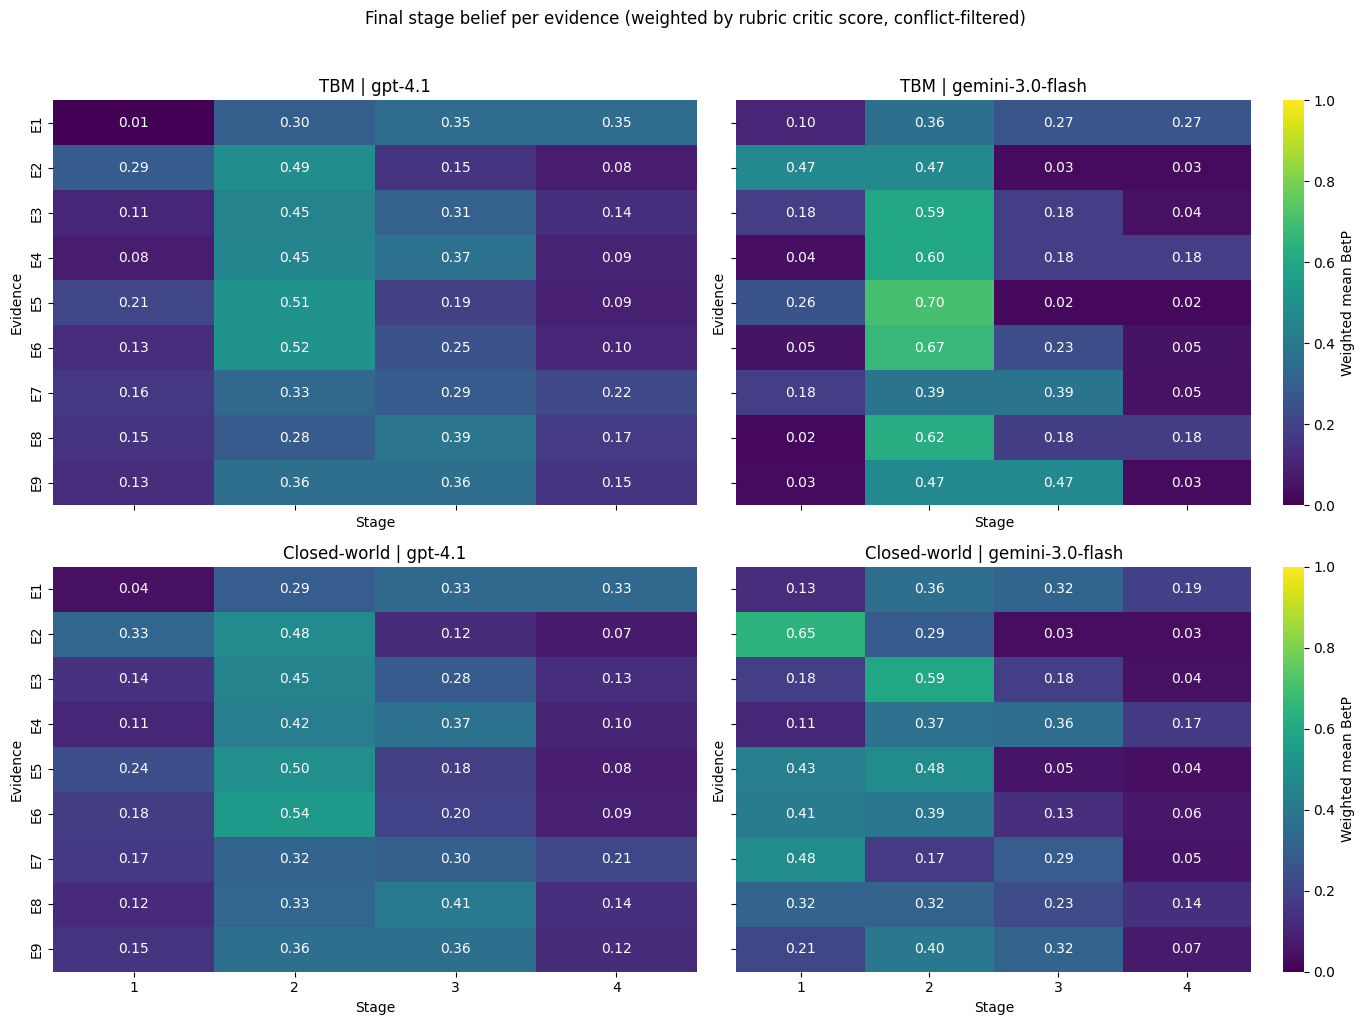

In [81]:
# --- Final visualization: weighted mean BetP heatmaps ---

methods = ["TBM", "Closed-world"]
models = [data.experiments[tag]["modelId"] for tag in data.tags]

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = np.array(axes)

for i, method in enumerate(methods):
    for j, model in enumerate(models):
        ax = axes[i, j]

        sub = agg_all[(agg_all["method"] == method) & (agg_all["model"] == model)].copy()
        pivot = sub.pivot(index="evidence", columns="stage", values="mean_betP")

        # Ensure consistent axis order
        evidence_order = sorted(pivot.index, key=lambda x: int(re.search(r"E(\d+)", x).group(1)))
        pivot = pivot.reindex(index=evidence_order)
        pivot = pivot.reindex(columns=stages)

        sns.heatmap(
            pivot,
            ax=ax,
            cmap="viridis",
            vmin=0.0,
            vmax=1.0,
            annot=True,
            fmt=".2f",
            cbar=(j == 1),
            cbar_kws={"label": "Weighted mean BetP"} if j == 1 else None,
        )

        ax.set_title(f"{method} | {model}")
        ax.set_xlabel("Stage")
        ax.set_ylabel("Evidence")

plt.suptitle(
    "Final stage belief per evidence (weighted by rubric critic score, conflict-filtered)",
    y=1.02,
)
plt.tight_layout()
plt.show()

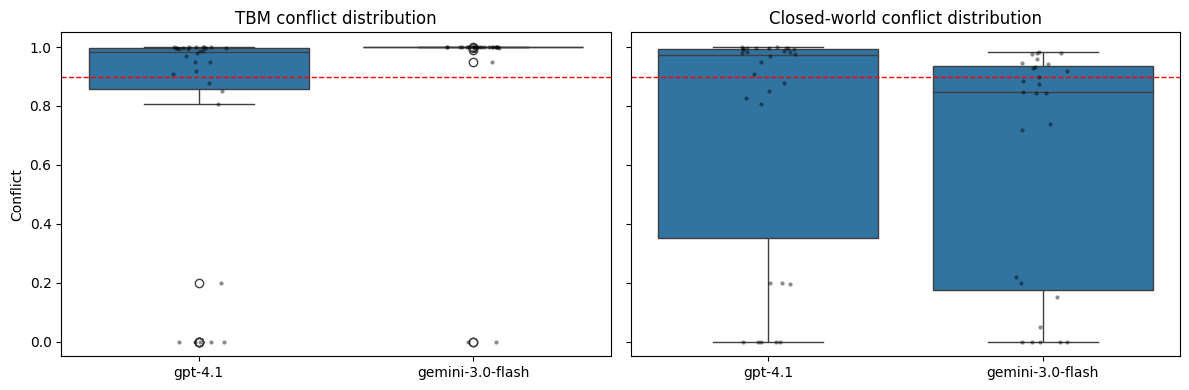

Conflict threshold: 0.9


method,model,n_total,n_usable,usable_pct,mean_conflict,median_conflict,mean_max_betP_usable
Closed-world,gemini-3.0-flash,30,17,56.7%,0.623,0.848,0.903
Closed-world,gpt-4.1,30,12,40.0%,0.722,0.974,0.911
TBM,gemini-3.0-flash,30,2,6.7%,0.923,1.000,0.998
TBM,gpt-4.1,30,9,30.0%,0.778,0.983,0.933


In [82]:
# --- Conflict comparison + summary table ---

conflict_plot_df = pd.concat(
    [
        combined_df[["model", "tag", "rubricId", "conflict"]].assign(method="TBM"),
        combined_closed_df[["model", "tag", "rubricId", "conflict"]].assign(method="Closed-world"),
    ],
    ignore_index=True,
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for ax, method in zip(axes, ["TBM", "Closed-world"]):
    sub = conflict_plot_df[conflict_plot_df["method"] == method]
    sns.boxplot(data=sub, x="model", y="conflict", ax=ax)
    sns.stripplot(data=sub, x="model", y="conflict", ax=ax, color="black", alpha=0.45, size=3)
    ax.axhline(CONFLICT_THRESHOLD_FINAL, color="red", linestyle="--", linewidth=1)
    ax.set_title(f"{method} conflict distribution")
    ax.set_xlabel("")
    ax.set_ylabel("Conflict")

plt.tight_layout()
plt.show()


# Summary table (per method x model)
summary_rows = []
for method, df in [("TBM", combined_df), ("Closed-world", combined_closed_df)]:
    for tag in data.tags:
        model = data.experiments[tag]["modelId"]
        sub = df[df["tag"] == tag].copy()

        n_total = len(sub)
        n_usable = int((sub["conflict"] < CONFLICT_THRESHOLD_FINAL).sum())
        usable_pct = (100.0 * n_usable / n_total) if n_total else np.nan

        usable = sub[sub["conflict"] < CONFLICT_THRESHOLD_FINAL]
        mean_conviction = usable["max_betP"].mean() if not usable.empty else np.nan

        summary_rows.append(
            {
                "method": method,
                "model": model,
                "n_total": n_total,
                "n_usable": n_usable,
                "usable_pct": usable_pct,
                "mean_conflict": sub["conflict"].mean() if n_total else np.nan,
                "median_conflict": sub["conflict"].median() if n_total else np.nan,
                "mean_max_betP_usable": mean_conviction,
            }
        )

summary_df = pd.DataFrame(summary_rows).sort_values(["method", "model"])

print(f"Conflict threshold: {CONFLICT_THRESHOLD_FINAL}")
display(
    summary_df.style.format(
        {
            "usable_pct": "{:.1f}%",
            "mean_conflict": "{:.3f}",
            "median_conflict": "{:.3f}",
            "mean_max_betP_usable": "{:.3f}",
        }
    ).hide(axis="index")
)